##Importing Library

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statsmodels.api as sm
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import ParameterSampler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import ParameterGrid
from sklearn.preprocessing import MinMaxScaler
from prophet import Prophet
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

In [ ]:
# Load the dataset

market_data = pd.read_csv('MarketPricePrediction.csv')

# Data Cleaning

market_data['date'] = pd.to_datetime(market_data['date'], format='%B-%Y')

#  Handling Missing Values

missing_values = market_data.isnull().sum()


for column in market_data.columns:
    if market_data[column].dtype == 'object':
        market_data[column].fillna(market_data[column].mode()[0], inplace=True)
    else:
        market_data[column].fillna(market_data[column].mean(), inplace=True)

Encoding Categorical Variables

categorical_cols = ['market', 'state', 'city', 'month']
encoder = OneHotEncoder(sparse=False, drop='first')
encoded_data = encoder.fit_transform(market_data[categorical_cols])

# Creating a DataFrame from the encoded data
encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(categorical_cols))


market_data.drop(columns=categorical_cols, inplace=True)
market_data = pd.concat([market_data, encoded_df], axis=1)


market_data.head(), market_data.info(), missing_values


SyntaxError: invalid syntax (<ipython-input-20-623c37291501>, line 20)

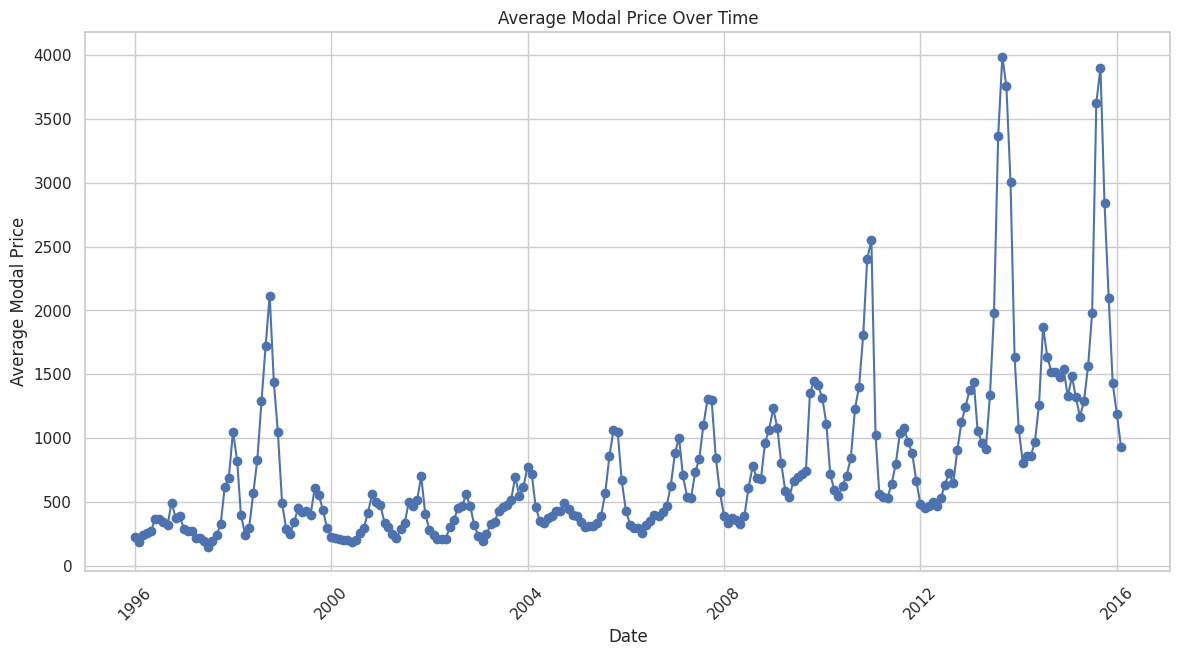

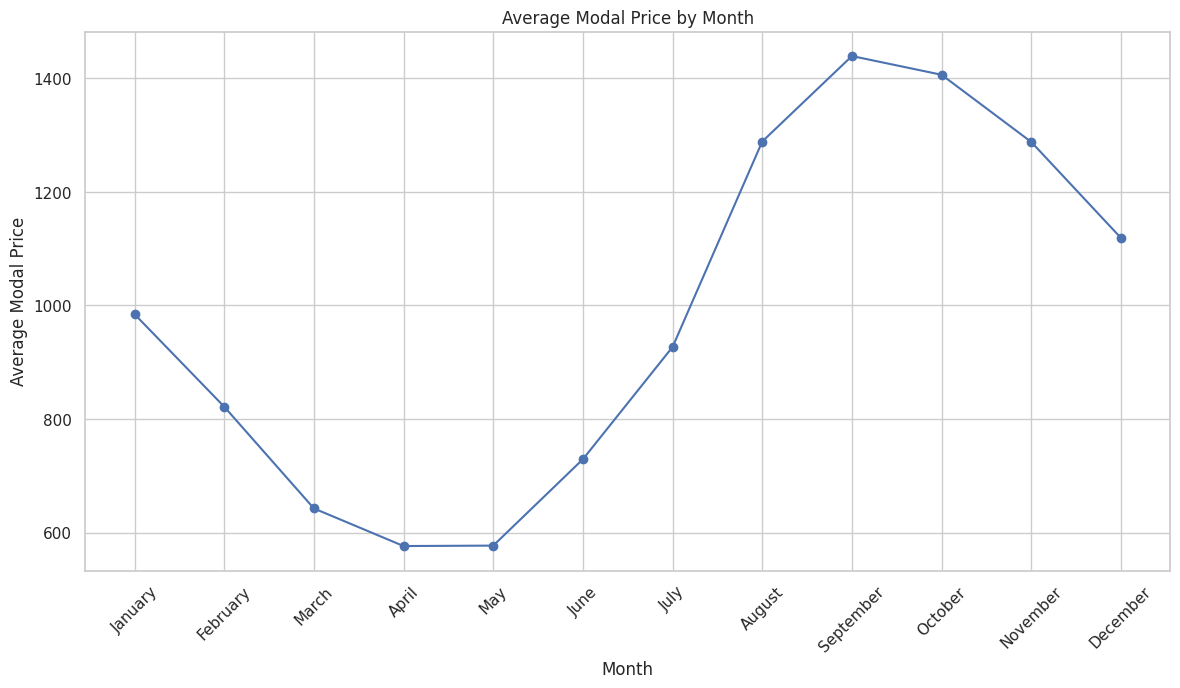

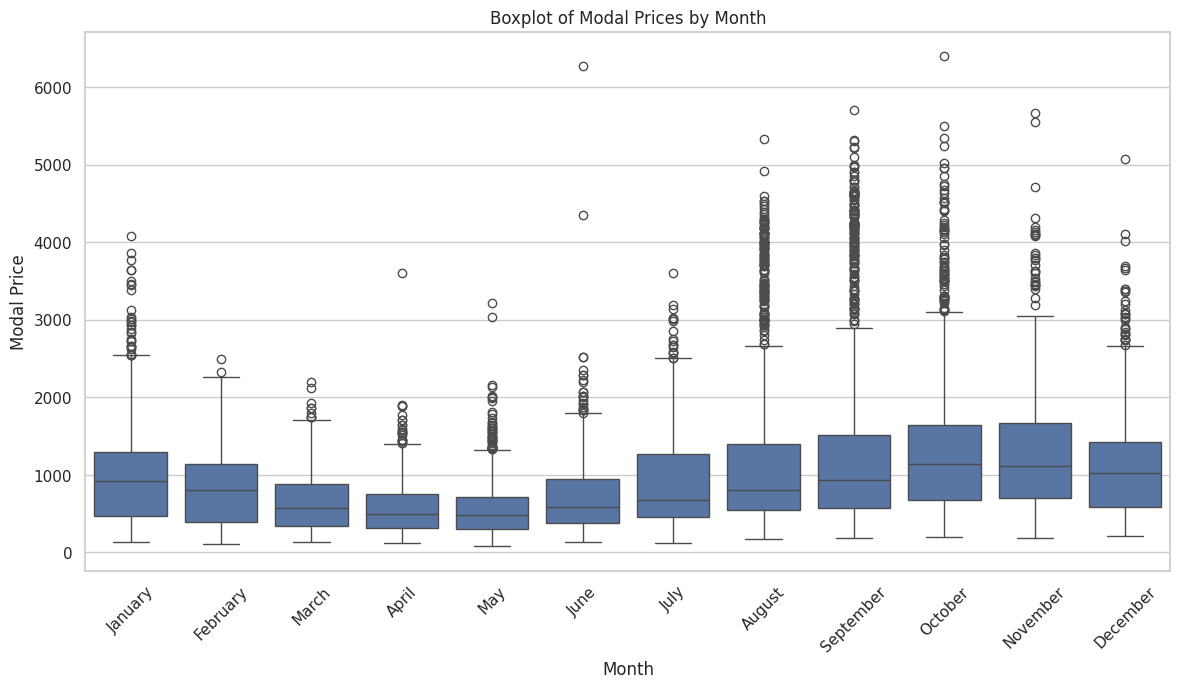

In [ ]:
# Set the plot style
sns.set(style="whitegrid")

# Create a time series of average modal prices over time
market_data['year_month'] = market_data['date'].dt.to_period('M')
avg_price_over_time = market_data.groupby('year_month')['priceMod'].mean()

# Plot the average modal price over time
plt.figure(figsize=(14, 7))
plt.plot(avg_price_over_time.index.to_timestamp(), avg_price_over_time, marker='o')
plt.title('Average Modal Price Over Time')
plt.xlabel('Date')
plt.ylabel('Average Modal Price')
plt.xticks(rotation=45)
plt.show()

# Seasonality: Average prices by month
avg_price_by_month = market_data.groupby(market_data['date'].dt.month)['priceMod'].mean()
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

# Plot the average modal price by month
plt.figure(figsize=(14, 7))
plt.plot(months, avg_price_by_month, marker='o')
plt.title('Average Modal Price by Month')
plt.xlabel('Month')
plt.ylabel('Average Modal Price')
plt.xticks(rotation=45)
plt.show()

# Boxplot to identify outliers in the price data
market_data['month'] = market_data['date'].dt.month_name()
plt.figure(figsize=(14, 7))
sns.boxplot(x='month', y='priceMod', data=market_data, order=months)
plt.title('Boxplot of Modal Prices by Month')
plt.xlabel('Month')
plt.ylabel('Modal Price')
plt.xticks(rotation=45)
plt.show()


In [ ]:
# Create lagged features
market_data['priceMod_lag1'] = market_data['priceMod'].shift(1)
market_data['priceMod_lag2'] = market_data['priceMod'].shift(2)

# Create rolling statistics features
market_data['priceMod_roll_mean_3'] = market_data['priceMod'].rolling(window=3).mean()
market_data['priceMod_roll_std_3'] = market_data['priceMod'].rolling(window=3).std()
market_data['priceMod_roll_mean_6'] = market_data['priceMod'].rolling(window=6).mean()
market_data['priceMod_roll_std_6'] = market_data['priceMod'].rolling(window=6).std()

# Create seasonal indicators
market_data['month'] = market_data['date'].dt.month
market_data['quarter'] = market_data['date'].dt.quarter

# Drop rows with NaN values generated by lagged and rolling features
market_data.dropna(inplace=True)

# Display the updated dataset
market_data.head(), market_data.info()


<class 'pandas.core.frame.DataFrame'>
Index: 10217 entries, 10 to 10226
Columns: 281 entries, year to quarter
dtypes: datetime64[ns](1), float64(272), int32(2), int64(5), period[M](1)
memory usage: 21.9 MB


(    year  quantity  priceMin  priceMax  priceMod       date  market_AGRA(UP)  \
 10  2010       555      1143      1460      1322 2010-02-01              0.0   
 11  2011       300       950      1400      1125 2011-02-01              0.0   
 12  2012       675       510       650       570 2012-02-01              0.0   
 13  2013       845      1400      1843      1629 2013-02-01              0.0   
 14  2014      1115       831      1163       983 2014-02-01              0.0   
 
     market_AHMEDABAD(GUJ)  market_AHMEDNAGAR(MS)  market_AJMER(RAJ)  ...  \
 10                    0.0                    0.0                0.0  ...   
 11                    0.0                    0.0                0.0  ...   
 12                    0.0                    0.0                0.0  ...   
 13                    0.0                    0.0                0.0  ...   
 14                    0.0                    0.0                0.0  ...   
 
     month_September  year_month  month  priceMo

##Model Selction And Training

In [ ]:
# Split the data into training and testing sets
train_size = int(len(market_data) * 0.8)
train_data = market_data[:train_size]
test_data = market_data[train_size:]

train_data.shape, test_data.shape

((8173, 281), (2044, 281))

##1- ARIMA Model

In [ ]:
# Fit an ARIMA model
arima_order = (5, 1, 0)  # ARIMA(p, d, q)
arima_model = sm.tsa.ARIMA(train_data['priceMod'], order=arima_order)
arima_results = arima_model.fit()

# Forecast the prices
arima_forecast = arima_results.forecast(steps=len(test_data))

# Evaluate the ARIMA model
arima_rmse = np.sqrt(np.mean((arima_forecast - test_data['priceMod'])**2))
arima_rmse


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

917.4621843808329

##2- SARIMA Model

In [ ]:
# Fit a SARIMA model
sarima_order = (5, 1, 0)  # ARIMA(p, d, q)
seasonal_order = (1, 1, 1, 12)  # Seasonal order (P, D, Q, s)
sarima_model = sm.tsa.SARIMAX(train_data['priceMod'], order=sarima_order, seasonal_order=seasonal_order)
sarima_results = sarima_model.fit()

# Forecast the prices
sarima_forecast = sarima_results.forecast(steps=len(test_data))

# Evaluate the SARIMA model
sarima_rmse = np.sqrt(np.mean((sarima_forecast - test_data['priceMod'])**2))
sarima_rmse

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


1013.7257715407133

##3- Prophet Model

In [ ]:
# Prepare the data for Prophet
prophet_train = train_data[['date', 'priceMod']].rename(columns={'date': 'ds', 'priceMod': 'y'})

# Fit the Prophet model
prophet_model = Prophet()
prophet_model.fit(prophet_train)

# Create a dataframe for future dates
future_dates = prophet_model.make_future_dataframe(periods=len(test_data), freq='M')
forecast = prophet_model.predict(future_dates)

# Evaluate the Prophet model
prophet_forecast = forecast['yhat'][-len(test_data):].values
prophet_rmse = np.sqrt(np.mean((prophet_forecast - test_data['priceMod'])**2))
prophet_rmse


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp90hcdi_p/58xrcw93.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp90hcdi_p/h01tn_41.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=74790', 'data', 'file=/tmp/tmp90hcdi_p/58xrcw93.json', 'init=/tmp/tmp90hcdi_p/h01tn_41.json', 'output', 'file=/tmp/tmp90hcdi_p/prophet_modeli2a_s3yo/prophet_model-20240521203929.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:39:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:39:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


2937.3112179944615

##4- LTSM Model

In [ ]:
# Prepare the data for LSTM
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(market_data['priceMod'].values.reshape(-1, 1))

# Create a dataset with a lookback period
lookback = 1
X, y = [], []
for i in range(lookback, len(scaled_data)):
    X.append(scaled_data[i-lookback:i, 0])
    y.append(scaled_data[i, 0])
X, y = np.array(X), np.array(y)

# Split the data into training and testing sets
X_train, X_test = X[:train_size-lookback], X[train_size-lookback:]
y_train, y_test = y[:train_size-lookback], y[train_size-lookback:]

# Reshape the data to be 3-dimensional
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=50))
model.add(Dense(1))

# Compile and fit the model
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=20, batch_size=32)

# Predict the prices
lstm_forecast = model.predict(X_test)
lstm_forecast = scaler.inverse_transform(lstm_forecast)

# Evaluate the LSTM model
lstm_rmse = np.sqrt(np.mean((lstm_forecast - test_data['priceMod'].values)**2))
lstm_rmse


Epoch 1/20
256/256 [==============================] - 6s 6ms/step - loss: 0.0163
Epoch 2/20
256/256 [==============================] - 1s 4ms/step - loss: 0.0150
Epoch 3/20
256/256 [==============================] - 1s 4ms/step - loss: 0.0149
Epoch 4/20
256/256 [==============================] - 1s 4ms/step - loss: 0.0147
Epoch 5/20
256/256 [==============================] - 1s 4ms/step - loss: 0.0147
Epoch 6/20
256/256 [==============================] - 1s 4ms/step - loss: 0.0145
Epoch 7/20
256/256 [==============================] - 1s 4ms/step - loss: 0.0144
Epoch 8/20
256/256 [==============================] - 1s 4ms/step - loss: 0.0143
Epoch 9/20
256/256 [==============================] - 1s 4ms/step - loss: 0.0142
Epoch 10/20
256/256 [==============================] - 1s 4ms/step - loss: 0.0142
Epoch 11/20
256/256 [==============================] - 1s 4ms/step - loss: 0.0142
Epoch 12/20
256/256 [==============================] - 2s 6ms/step - loss: 0.0142
Epoch 13/20
256/256 [====

845.2348719309111

## Visualaizing The error to make decision of the best one

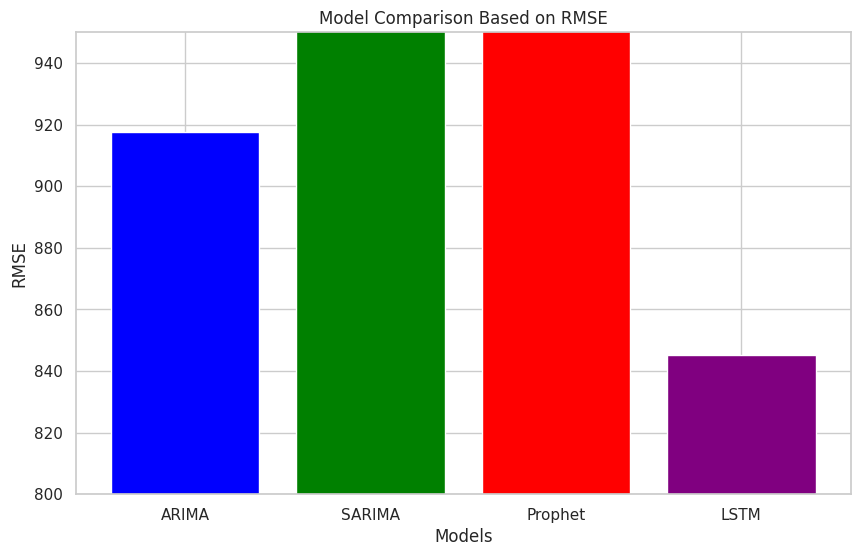

In [ ]:
rmse_values = {
    'ARIMA': arima_rmse,
    'SARIMA': sarima_rmse,
    'Prophet': prophet_rmse,
    'LSTM': lstm_rmse
}

# Create a bar chart to visualize the model comparisons
models = list(rmse_values.keys())
rmse = list(rmse_values.values())

plt.figure(figsize=(10, 6))
plt.bar(models, rmse, color=['blue', 'green', 'red', 'purple'])
plt.xlabel('Models')
plt.ylabel('RMSE')
plt.title('Model Comparison Based on RMSE')
plt.ylim(800, 950)
plt.show();

#After Performing these algorithms, it is seems that the LTSM Model has the lowest error. So, it is the best model for this case

##Model Evaluation

In [ ]:
lstm_mae = mean_absolute_error(test_data['priceMod'], lstm_forecast)
lstm_mse = mean_squared_error(test_data['priceMod'], lstm_forecast)
lstm_rmse = np.sqrt(lstm_mse)

print("LSTM Model Evaluation Metrics:")
print("Mean Absolute Error (MAE):", lstm_mae)
print("Mean Squared Error (MSE):", lstm_mse)
print("Root Mean Squared Error (RMSE):", lstm_rmse)

LSTM Model Evaluation Metrics:
Mean Absolute Error (MAE): 514.9352534045912
Mean Squared Error (MSE): 539099.3998230185
Root Mean Squared Error (RMSE): 734.2338863216669


##Fine Tuning

In [ ]:
# Define a parameter grid
param_grid = {
    'units': [50, 100],
    'layers': [1, 2],
    'batch_size': [32, 64],
    'epochs': [20, 50],
    'learning_rate': [0.001, 0.01]
}

# Use ParameterSampler for random search
param_list = list(ParameterSampler(param_grid, n_iter=10, random_state=42))

def build_and_train_lstm(units, layers, batch_size, epochs, learning_rate):
    model = Sequential()
    for i in range(layers):
        return_sequences = i < layers - 1
        model.add(LSTM(units=units, return_sequences=return_sequences, input_shape=(X_train.shape[1], 1)))
    model.add(Dense(1))

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)

    lstm_forecast = model.predict(X_test)
    lstm_forecast = scaler.inverse_transform(lstm_forecast)

    lstm_rmse = np.sqrt(np.mean((lstm_forecast - test_data['priceMod'].values)**2))
    return lstm_rmse

# Iterate over the parameter list and find the best hyperparameters
best_rmse = float('inf')
best_params = None

for params in param_list:
    lstm_rmse = build_and_train_lstm(**params)
    if lstm_rmse < best_rmse:
        best_rmse = lstm_rmse
        best_params = params

print("Best Parameters: ", best_params)
print("Best RMSE: ", best_rmse)

# Retrain the best model with the best parameters
best_model = Sequential()
for i in range(best_params['layers']):
    return_sequences = i < best_params['layers'] - 1
    best_model.add(LSTM(units=best_params['units'], return_sequences=return_sequences, input_shape=(X_train.shape[1], 1)))
best_model.add(Dense(1))

best_optimizer = Adam(learning_rate=best_params['learning_rate'])
best_model.compile(optimizer=best_optimizer, loss='mean_squared_error')
best_model.fit(X_train, y_train, epochs=best_params['epochs'], batch_size=best_params['batch_size'], verbose=0)

# Predict and evaluate the best model
best_lstm_forecast = best_model.predict(X_test)
best_lstm_forecast = scaler.inverse_transform(best_lstm_forecast)

# Compute evaluation metrics
best_lstm_mae = mean_absolute_error(test_data['priceMod'], best_lstm_forecast)
best_lstm_mse = mean_squared_error(test_data['priceMod'], best_lstm_forecast)
best_lstm_rmse = np.sqrt(best_lstm_mse)

print("Best LSTM Model Evaluation Metrics:")
print("Mean Absolute Error (MAE):", best_lstm_mae)
print("Mean Squared Error (MSE):", best_lstm_mse)
print("Root Mean Squared Error (RMSE):", best_lstm_rmse)

64/64 [==============================] - 1s 2ms/step
Best Parameters:  {'units': 50, 'learning_rate': 0.001, 'layers': 1, 'epochs': 20, 'batch_size': 32}
Best RMSE:  835.6290198552464
64/64 [==============================] - 1s 2ms/step
Best LSTM Model Evaluation Metrics:
Mean Absolute Error (MAE): 494.30312201094955
Mean Squared Error (MSE): 533398.6362341084
Root Mean Squared Error (RMSE): 730.3414518114855


##Visualizing after fine-tuning

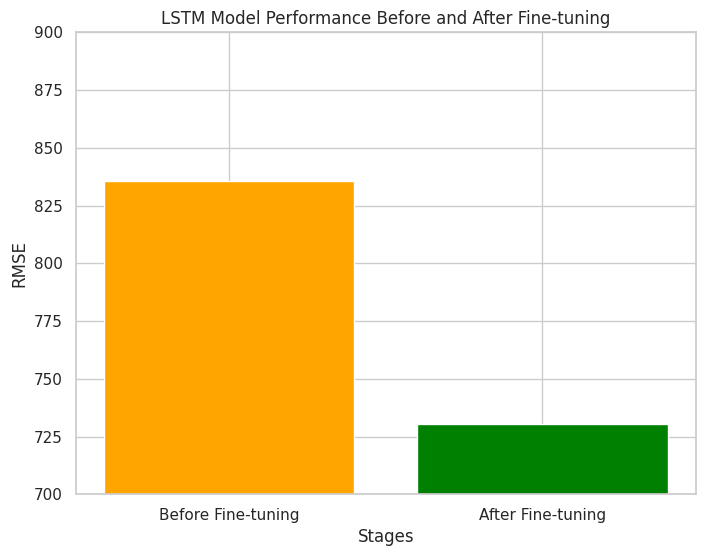

In [ ]:
rmse_before_after = {
    'Before Fine-tuning': lstm_rmse,
    'After Fine-tuning': best_lstm_rmse
}

# Create a bar chart to visualize the comparison
fine_tuning_stages = list(rmse_before_after.keys())
rmse_values = list(rmse_before_after.values())

plt.figure(figsize=(8, 6))
plt.bar(fine_tuning_stages, rmse_values, color=['orange', 'green'])
plt.xlabel('Stages')
plt.ylabel('RMSE')
plt.title('LSTM Model Performance Before and After Fine-tuning')
plt.ylim(700, 900)
plt.show()

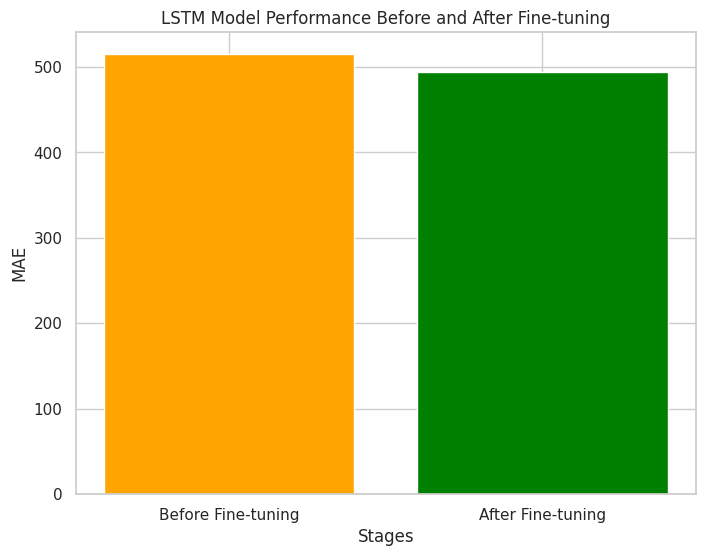

In [ ]:
mae_before_after = {
    'Before Fine-tuning': lstm_mae,
    'After Fine-tuning': best_lstm_mae
}

# Create a bar chart to visualize the comparison
fine_tuning_stages = list(mae_before_after.keys())
rmse_values = list(mae_before_after.values())

plt.figure(figsize=(8, 6))
plt.bar(fine_tuning_stages, rmse_values, color=['orange', 'green'])
plt.xlabel('Stages')
plt.ylabel('MAE')
plt.title('LSTM Model Performance Before and After Fine-tuning')
plt.show()

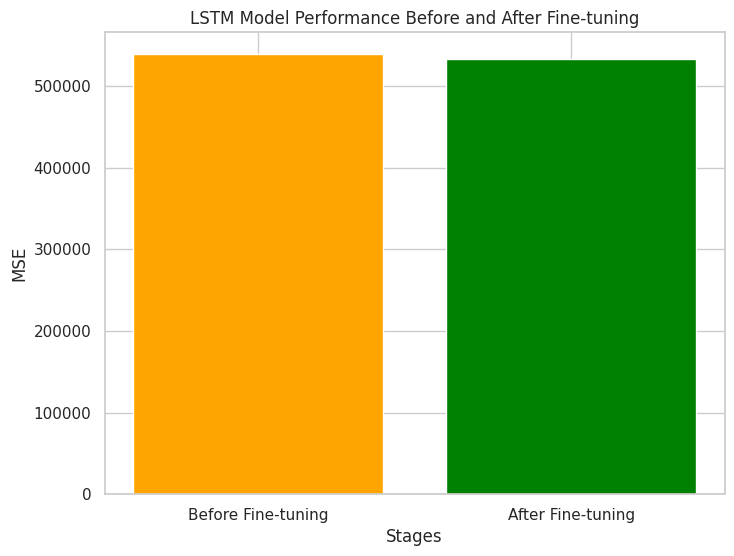

In [ ]:
mse_before_after = {
    'Before Fine-tuning': lstm_mse,
    'After Fine-tuning': best_lstm_mse
}

# Create a bar chart to visualize the comparison
fine_tuning_stages = list(mse_before_after.keys())
rmse_values = list(mse_before_after.values())

plt.figure(figsize=(8, 6))
plt.bar(fine_tuning_stages, rmse_values, color=['orange', 'green'])
plt.xlabel('Stages')
plt.ylabel('MSE')
plt.title('LSTM Model Performance Before and After Fine-tuning')
plt.show()